<a href="https://colab.research.google.com/github/fdebrain/kaggle-facial-landmark-detection/blob/main/Kaggle_Facial_Landmark_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-on Facial Landmark Detection Kaggle Competition
Notebook written by [Frédéric Debraine](https://www.linkedin.com/in/fdebraine/)


[Official Competition Link](https://www.kaggle.com/c/facial-keypoints-detection/overview)

In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPool2D, Dropout, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.utils.data_utils import Sequence

## 1. Data download

For more info about the Kaggle API see https://www.kaggle.com/docs/api

The dataset can also be downloaded directly at https://www.kaggle.com/c/facial-keypoints-detection/data

In [ ]:
# Upload your kaggle.json file (might require a few seconds after upload)
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# Download dataset from Kaggle
!kaggle competitions download -c facial-keypoints-detection

In [ ]:
# Unzip data
!mkdir data/
!unzip -q training.zip -d data/train && rm training.zip
!unzip -q test.zip -d data/test && rm test.zip

## 2. Data analysis and preprocessing

In this section we tackle the following topics:
- Loading and formatting the data (image normaliation).
- Getting a visual and statistical overview of the dataset.
- Handling missing data and outliers.

In [ ]:
# Helper functions of this section
def format_image(img_row):
    """ Extract image from a pandas DataFrame row and normalize it in a [0,1] range. """
    img = img_row.split(' ')
    img = np.array(img, dtype=np.float32)
    img = img.reshape((96,96,1))
    img = img / 255.
    return img

def format_keypoints(keypoint):
    """ Normalize keypoints coordinates to lie in a [-1,1] range. """
    return (keypoint - 48.) /  48.

def unformat_keypoints(keypoint):
    """ Unormalize keypoints coordinates to lie in a [0,96] range. """
    return keypoint*48 + 48

def show_sample(img, keypoints, axis, color='b'):
    """ Display the target keypoints on top of the input image. """
    axis.scatter(keypoints[0::2], keypoints[1::2], s=10, c=color)
    axis.imshow(img.squeeze(), cmap='gray')

def show_random_samples(X, y, n_rows=2, n_cols=5):
    """ Display a random subset of image-keypoints samples. """
    fig = plt.figure(figsize=(2*n_cols, 2*n_rows), dpi=100)

    for i, idx in enumerate(np.random.randint(0, len(y), n_rows*n_cols)):
        axis = fig.add_subplot(n_rows, n_cols, i+1, xticks=[], yticks=[])
        show_sample(X[idx], y[idx], axis=axis)
        axis.set_title(f'Sample #{idx}')

In [ ]:
# Read data
train_dir = 'data/train/training.csv'
test_dir = 'data/test/test.csv'

train_data = pd.read_csv(train_dir)  
test_data = pd.read_csv(test_dir)

In [ ]:
# Data overview
train_data.sample(5).T

5722  ...                                               5650
left_eye_center_x                                                    67.9701  ...                                            68.4409
left_eye_center_y                                                    35.5224  ...                                            39.2712
right_eye_center_x                                                   31.0775  ...                                            29.2836
right_eye_center_y                                                    40.134  ...                                            39.2712
left_eye_inner_corner_x                                                  NaN  ...                                                NaN
left_eye_inner_corner_y                                                  NaN  ...                                                NaN
left_eye_outer_corner_x                                                  NaN  ...                                                NaN
left_eye_outer_corner_y                                                  NaN  ...                                                NaN
right_eye_inner_corner_x                                                 NaN  ...                                                NaN
right_eye_inner_corner_y                                                 NaN  ...                                                NaN
right_eye_outer_corner_x                                                 NaN  ...                                                NaN
right_eye_outer_corner_y                                                 NaN  ...                                                NaN
left_eyebrow_inner_end_x                                                 NaN  ...                                                NaN
left_eyebrow_inner_end_y                                                 NaN  ...                                                NaN
left_eyebrow_outer_end_x                                                 NaN  ...                                                NaN
left_eyebrow_outer_end_y                                                 NaN  ...                                                NaN
right_eyebrow_inner_end_x                                                NaN  ...                                                NaN
right_eyebrow_inner_end_y                                                NaN  ...                                                NaN
right_eyebrow_outer_end_x                                                NaN  ...                                                NaN
right_eyebrow_outer_end_y                                                NaN  ...                                                NaN
nose_tip_x                                                            52.779  ...                                            50.7817
nose_tip_y                                                           61.2929  ...                                            72.2863
mouth_left_corner_x                                                      NaN  ...                                                NaN
mouth_left_corner_y                                                      NaN  ...                                                NaN
mouth_right_corner_x                                                     NaN  ...                                                NaN
mouth_right_corner_y                                                     NaN  ...                                                NaN
mouth_center_top_lip_x                                                   NaN  ...                                                NaN
mouth_center_top_lip_y                                                   NaN  ...                                                NaN
mouth_center_bottom_lip_x                                            53.5928  ...                                            48.0944
mouth_center_bottom_lip_y                                            75.1276  ... 

In [ ]:
# Check the target keypoints statistics
train_data.describe()

left_eye_center_x  ...  mouth_center_bottom_lip_y
count        7039.000000  ...                7016.000000
mean           66.359021  ...                  78.970146
std             3.448233  ...                   5.407844
min            22.763345  ...                  25.850503
25%            65.082895  ...                  75.549715
50%            66.497566  ...                  78.696326
75%            68.024752  ...                  82.233993
max            94.689280  ...                  95.808983

[8 rows x 30 columns]

In [ ]:
# Check for missing training data
print(f'Train sample: {len(train_data)}')

print('Pourcentage of missing values:')
train_data.isna().mean().round(4) * 100

Train sample: 7049
Pourcentage of missing values:


left_eye_center_x             0.14
left_eye_center_y             0.14
right_eye_center_x            0.18
right_eye_center_y            0.18
left_eye_inner_corner_x      67.78
left_eye_inner_corner_y      67.78
left_eye_outer_corner_x      67.84
left_eye_outer_corner_y      67.84
right_eye_inner_corner_x     67.83
right_eye_inner_corner_y     67.83
right_eye_outer_corner_x     67.83
right_eye_outer_corner_y     67.83
left_eyebrow_inner_end_x     67.80
left_eyebrow_inner_end_y     67.80
left_eyebrow_outer_end_x     68.44
left_eyebrow_outer_end_y     68.44
right_eyebrow_inner_end_x    67.80
right_eyebrow_inner_end_y    67.80
right_eyebrow_outer_end_x    68.28
right_eyebrow_outer_end_y    68.28
nose_tip_x                    0.00
nose_tip_y                    0.00
mouth_left_corner_x          67.81
mouth_left_corner_y          67.81
mouth_right_corner_x         67.80
mouth_right_corner_y         67.80
mouth_center_top_lip_x       67.73
mouth_center_top_lip_y       67.73
mouth_center_bottom_

In [ ]:
# Impute missing values

# Solution 1 - Drop all samples with one or multiple missing values
# train_data.dropna(inplace=True)

# Solution 2 - Replace NaN values by last valid value
# train_data.fillna(method = 'ffill', inplace=True)

# Solution 3 - Replace NaN values with each feature median
train_data.fillna(train_data.describe().T['50%'], inplace=True)

# Solution 4 - Replace NaN values with each feature mean
# train_data.fillna(train_data.describe().T['mean'], inplace=True)

# Check imputed data
train_data.sample(5).T

3376  ...                                               6141
left_eye_center_x                                                    70.4764  ...                                            63.0518
left_eye_center_y                                                    38.2143  ...                                            44.5315
right_eye_center_x                                                    29.284  ...                                            33.4239
right_eye_center_y                                                    39.696  ...                                            39.9549
left_eye_inner_corner_x                                              59.3046  ...                                            59.3046
left_eye_inner_corner_y                                               37.878  ...                                             37.878
left_eye_outer_corner_x                                              73.2478  ...                                            73.2478
left_eye_outer_corner_y                                               37.639  ...                                             37.639
right_eye_inner_corner_x                                             36.6516  ...                                            36.6516
right_eye_inner_corner_y                                             37.9441  ...                                            37.9441
right_eye_outer_corner_x                                              22.536  ...                                             22.536
right_eye_outer_corner_y                                             37.8671  ...                                            37.8671
left_eyebrow_inner_end_x                                              56.245  ...                                             56.245
left_eyebrow_inner_end_y                                             29.5289  ...                                            29.5289
left_eyebrow_outer_end_x                                             79.7842  ...                                            79.7842
left_eyebrow_outer_end_y                                             29.7738  ...                                            29.7738
right_eyebrow_inner_end_x                                            39.2988  ...                                            39.2988
right_eyebrow_inner_end_y                                            29.5693  ...                                            29.5693
right_eyebrow_outer_end_x                                            15.7857  ...                                            15.7857
right_eyebrow_outer_end_y                                            30.3202  ...                                            30.3202
nose_tip_x                                                           48.8429  ...                                            48.3582
nose_tip_y                                                           72.5907  ...                                            70.0645
mouth_left_corner_x                                                  63.1783  ...                                            63.1783
mouth_left_corner_y                                                  75.7787  ...                                            75.7787
mouth_right_corner_x                                                 32.9823  ...                                            32.9823
mouth_right_corner_y                                                 76.0006  ...                                            76.0006
mouth_center_top_lip_x                                               47.9055  ...                                            47.9055
mouth_center_top_lip_y                                               72.6052  ...                                            72.6052
mouth_center_bottom_lip_x                                            54.4735  ...                                            43.5407
mouth_center_bottom_lip_y                                            85.3338  ... 

In [ ]:
# Format the data
X_train = np.array([ format_image(x) for x in train_data['Image'] ])
y_train = train_data.drop('Image', axis=1).values
X_test = np.array([ format_image(x) for x in test_data['Image'] ])

print(X_train.shape, y_train.shape, X_test.shape)

(7049, 96, 96, 1) (7049, 30) (1783, 96, 96, 1)


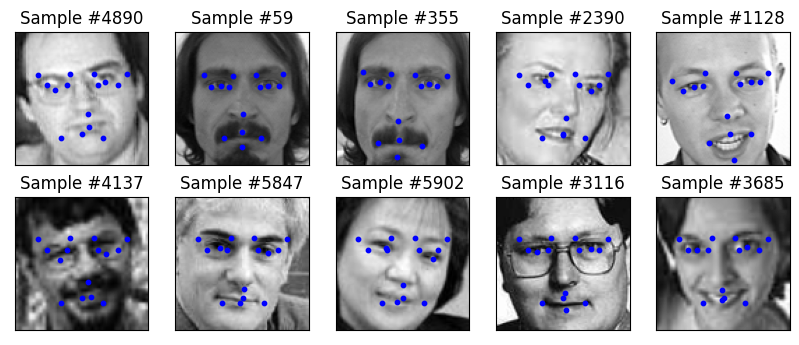

In [ ]:
# Display a random subset of training samples
show_random_samples(X_train, y_train)

Removing 310 outliers (duplicates or bad keypoints) - (4%)


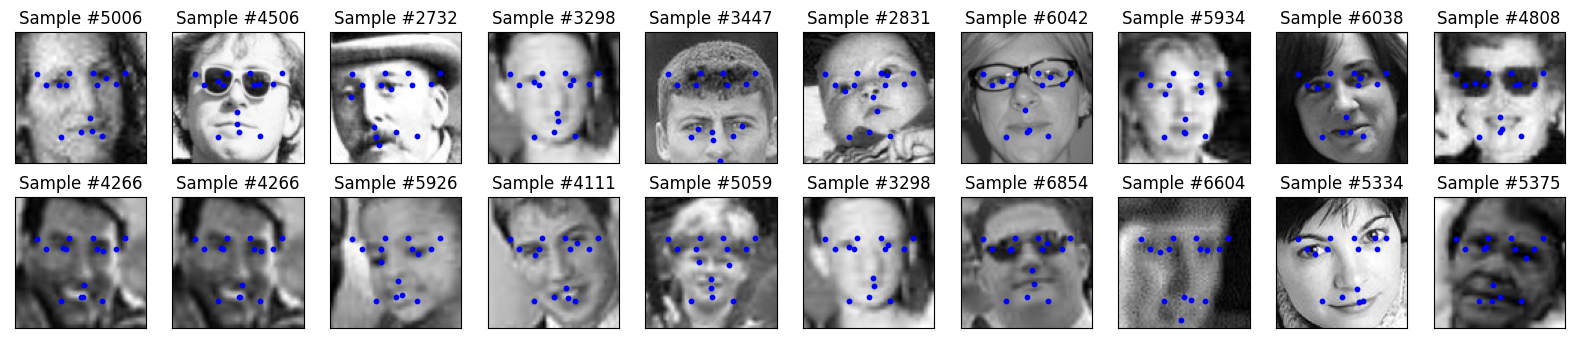

In [ ]:
# Optional - Remove bad training samples (run this cell only once)
bad_ids = [2284, 2289, 2292,
            2438, 2463, 2472, 2484, 
            2505, 2540, 2562, 2583, 
            2629, 
            2700, 2714, 2732, 2742, 2764, 2787,
            2811, 2818, 2824, 2829, 2831, 2850, 2862, 2866, 2870, 2895, 
            2915, 2982,
            3010, 3056, 3075, 3087, 
            3243, 3286, 3290, 3296, 3298,
            3303, 3307, 3316, 3351, 3371, 
            3423, 3434, 3447, 3469, 3489, 
            3509, 3510, 3530, 3552, 3556, 
            3644, 3646, 3647, 
            3700, 3732, 3739, 
            3801, 3811, 3815, 3819, 3850, 3854, 3888, 
            3903, 3924, 3926, 3943, 3953, 3938, 3986, 
            4019, 4024, 4060, 4094, 
            4111, 4112, 4135, 4137, 4141, 4145, 4154, 4197,
            4203, 4263, 4266, 4276, 
            4315, 4359, 4385, 
            4409, 4414, 4427, 4444, 4445, 4460, 4480, 4482, 4489, 4490, 4491, 4493, 4495,
            4506, 4509, 4514, 4559, 4599, 
            4601, 4610, 4620, 4626, 4640, 4664, 4689, 4694, 4697,
            4702, 4717, 4745, 4731, 4765, 4780, 4786, 
            4808, 4811, 4815, 4826, 4828, 4832, 4839, 4885, 4890, 4899, 
            4902, 4919, 4922, 4927, 4942, 4950, 4953, 4960, 4963, 4968, 4990, 4999, 
            5006, 5013, 5025, 5026, 5032, 5056, 5059, 5063, 5067, 5070, 5071, 5092, 5097,
            5104, 5106, 5112, 5117, 5122, 5142, 5148, 5163, 5167, 5169, 
            5209, 5222, 5245, 5265, 5269, 
            5320, 5334, 5349, 5353, 5358, 5361, 5375, 
            5439, 5457, 5459, 5463, 5470, 5472, 5478, 5497, 
            5517, 5530, 5544, 5561, 5565, 5573, 
            5606, 5610, 5612, 5639, 5652, 5653, 5673, 5682, 5696,
            5773, 5785, 5791, 5795, 
            5813, 5853, 5861, 5867, 5871, 5882, 5886, 5890, 5896,
            5909, 5926, 5929, 5932, 5934, 5935, 5952, 5955, 5978, 5890,
            6038, 6042, 6061, 6082, 6087, 6093,
            6106, 6115, 6154, 6163, 6164, 6165, 
            6272, 6289,
            6315, 6341, 6367, 6386,  
            6405, 6407, 6415, 6425, 6454, 6487, 6492, 6493,
            6506, 6513, 6545, 6561, 6569, 6574, 6587, 
            6604, 6614, 6616, 6618, 6626, 6627, 6652, 6684, 6693, 
            6712, 6719, 6723, 6732, 6765, 6766, 6782, 
            6810, 6822, 6834, 6854, 6855, 6859, 6878, 6879, 6887, 6880,
            6903, 6904, 6906, 6918, 6921, 6948, 6957, 6978, 6979, 6985, 6986, 6997,
            7000, 7003, 7004, 7005, 7011, 7017, 7018, 7023, 7029]

n_cols = 10
n_rows = 2
fig = plt.figure(figsize=(2*n_cols, 2*n_rows), dpi=100)

for i, idx in enumerate(np.random.choice(bad_ids, n_rows*n_cols)):
    axis = fig.add_subplot(n_rows, n_cols, i+1, xticks=[], yticks=[])
    show_sample(X_train[idx], y_train[idx][:], axis)
    plt.title(f'Sample #{idx}')

print(f'Removing {len(bad_ids)} outliers (duplicates or bad keypoints) - ({100 * len(bad_ids) / len(y_train) :.0f}%)')
X_train = np.delete(X_train, bad_ids, axis=0)
y_train = np.delete(y_train, bad_ids, axis=0)

## 3. Data modelling

In [ ]:
# Helper functions of this section
def show_random_preds(model, X, n_rows=2, n_cols=5):
    fig = plt.figure(figsize=(2*n_cols, 2*n_rows), dpi=100)

    for i, idx in enumerate(np.random.randint(0, len(X), n_rows*n_cols)):
        X_input = X[idx:idx+1, ...]
        y_pred = model.predict(X_input).flatten()
        
        axis = fig.add_subplot(n_rows, n_cols, i+1, xticks=[], yticks=[])
        show_sample(X_input.squeeze(), y_pred, axis=axis)
        axis.set_title(f'Sample #{idx}')

def plot_loss(hist, metric='loss'):
    plt.plot(hist.history[metric])
    plt.plot(hist.history[f'val_{metric}'])
    plt.title(f'{metric.upper()} vs Epoch')
    plt.ylabel(metric.upper())
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()            

In [ ]:
print(f'Input size: {X_train.shape}')
print(f'Output size: {y_train.shape}')

Input size: (6740, 96, 96, 1)
Output size: (6740, 30)


### Model 1 - Small dense network


In [ ]:
# Architecture 1
def create_small_dense_network():
    model = Sequential()
    model.add(Input(shape=(96, 96, 1)))
    model.add(Flatten())
    model.add(Dense(units=100, activation='relu'))
    model.add(Dense(units=30, activation=None))

    return model

In [ ]:
# Train model
model1 = create_small_dense_network()

es = EarlyStopping(monitor='val_loss', patience=10)
mc = ModelCheckpoint('best_model1.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
hist1 = model1.fit(X_train, y_train, epochs=500, batch_size=256, verbose=1, validation_split=0.2, callbacks=[es, mc])

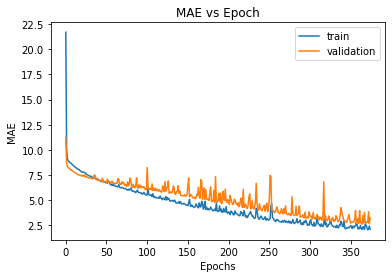

In [ ]:
# Show training and validation loss
plot_loss(hist1, metric='mae')

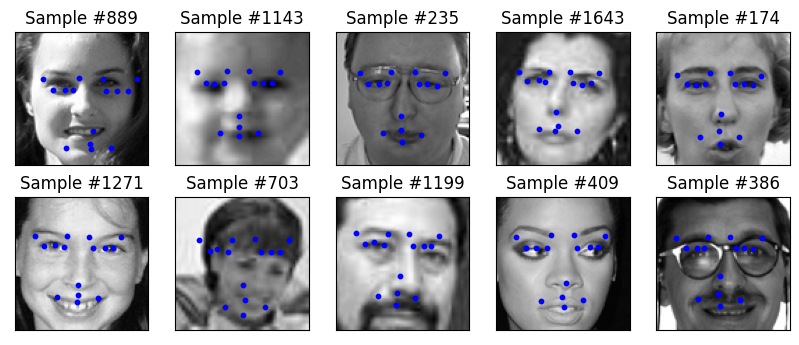

In [ ]:
# Visualize prediction on random test samples
model1.load_weights('best_model1.h5')
show_random_preds(model1, X_test)

**Kaggle results (public/private):** 4.53/4.49

### Model 2 - ConvNet

Inspired from [this notebook](https://www.kaggle.com/karanjakhar/facial-keypoint-detection)

In [ ]:
# Architecture 2
def create_convnet():
    model = Sequential()

    model.add(Convolution2D(32, (3,3), padding='same', input_shape=(96,96,1)))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    model.add(Convolution2D(32, (3,3), padding='same'))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, (3,3), padding='same'))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    model.add(Convolution2D(64, (3,3), padding='same'))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Convolution2D(96, (3,3), padding='same'))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    model.add(Convolution2D(96, (3,3), padding='same'))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Convolution2D(128, (3,3),padding='same'))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    model.add(Convolution2D(128, (3,3),padding='same'))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Convolution2D(256, (3,3),padding='same'))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    model.add(Convolution2D(256, (3,3),padding='same'))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Convolution2D(512, (3,3), padding='same'))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    model.add(Convolution2D(512, (3,3), padding='same'))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(30))

    return model

In [ ]:
# Train model
model2 = create_convnet()

es = EarlyStopping(monitor='val_loss', patience=10)
mc = ModelCheckpoint('best_model2.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

model2.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])
hist2 = model2.fit(X_train, y_train, epochs=50, batch_size=256, verbose=1, validation_split=0.2, callbacks=[es, mc])

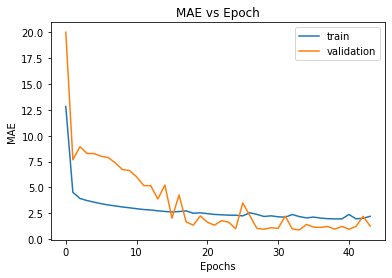

In [ ]:
# Show training and validation loss
plot_loss(hist2, metric='mae')

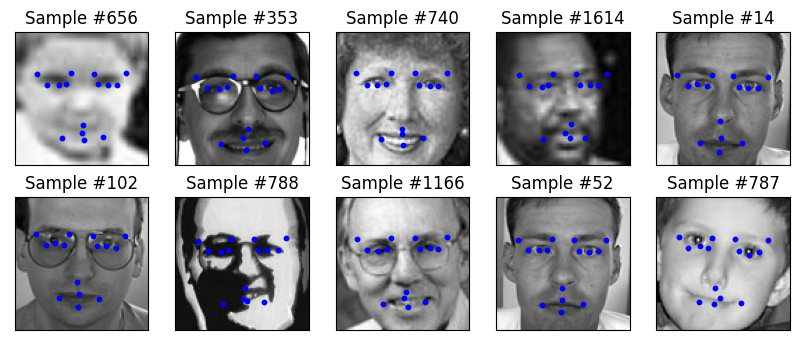

In [ ]:
# Visualize prediction on random test samples
model2.load_weights('best_model2.h5')
show_random_preds(model2, X_test)

**Kaggle results (public/private):** 3.01/2.66

### Model 3 - Augmentation + ConvNet

In [ ]:
# Helper functions of this section
class DataLoader(Sequence):
    def __init__(self, X, y, batch_size, augmentations=None, as_rgb=False):
        self.X, self.y = X, y
        self.batch_size = batch_size
        self.augment = augmentations
        self.shuffle = True
        self.as_rgb = as_rgb
        self.on_epoch_end()

    def __len__(self):
        """ Corresponds to the number of steps in one epoch. """
        return int(np.ceil(len(self.X) / float(self.batch_size)))

    def __getitem__(self, idx):
        indexes = self.indexes[idx*self.batch_size: (idx+1)*self.batch_size]
        batch_X = self.X[indexes, ...]
        batch_y = self.y[indexes, :]
        
        # Convert grayscale to RGB if needed (if you want to use a pre-trained ResNet for example)
        if self.as_rgb:
            batch_X = np.tile(batch_X, reps=(1,1,1,3))

        # Apply transformations on both images and keypoints
        if self.augment is not None:
            keypoints = np.array([ tuple(zip(point[::2], point[1::2])) for point in batch_y ])
            transformed = [ self.augment(image=x, keypoints=y) for x,y in zip(batch_X, keypoints) ]
            batch_X = np.stack([ z['image'] for z in transformed ], axis=0)
            batch_y = np.stack([ np.array(z['keypoints']).flatten(order='C') for z in transformed ], axis=0)

        return batch_X, batch_y

    def on_epoch_end(self):
        """ Shuffle the data after each epoch to avoid oscillation patterns in the loss. """
        self.indexes = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

# Architecture 3
def create_convnet2():
    model = Sequential()
    backbone = ResNet50(include_top=False, weights=None, input_shape=(96,96,1))
    model.add(backbone)
    model.add(Flatten())
    model.add(Dense(30))
    return model            

(5392, 96, 96, 1) (5392, 30)
(1348, 96, 96, 1) (1348, 30)


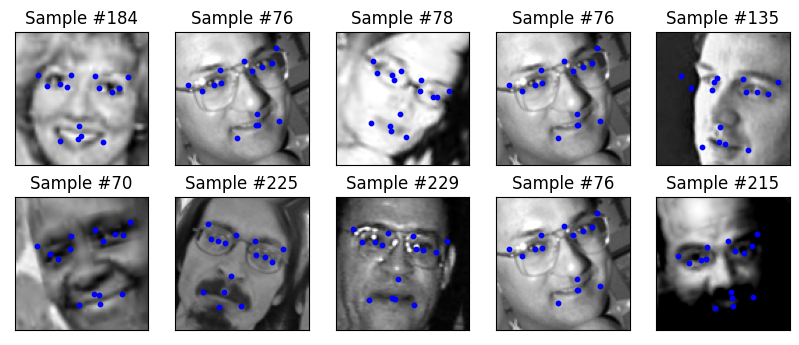

In [ ]:
# Add splitting to avoid leakage
X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Define augmentation strategy
transform = A.Compose([
    A.ShiftScaleRotate(rotate_limit=30, p=1.),
    A.RandomBrightnessContrast(p=1.),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

train_loader = DataLoader(X_train2, y_train2, batch_size=256, augmentations=transform)
print(X_train2.shape, y_train2.shape)
print(X_valid.shape, y_valid.shape)

# Visualize augmented data
x_batch, y_batch = train_loader[1]
show_random_samples(x_batch.squeeze(), y_batch)

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=20)
mc = ModelCheckpoint('best_model3.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

model3 = create_convnet()
model3.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])
hist3 = model3.fit(train_loader, steps_per_epoch=len(train_loader),
                   validation_data=(X_valid, y_valid),
                   epochs=500, verbose=1, callbacks=[es, mc])

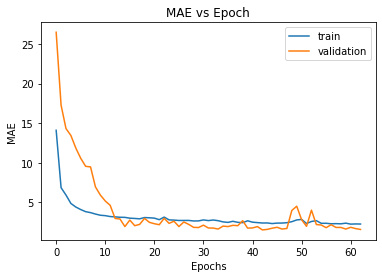

In [ ]:
plot_loss(hist3, metric='mae')

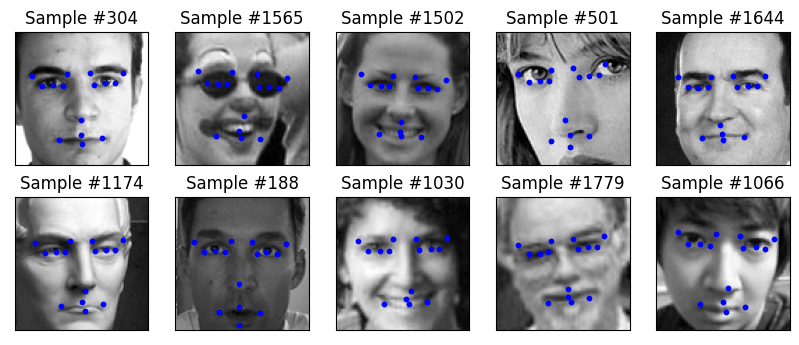

In [ ]:
model3.load_weights('best_model3.h5')
show_random_preds(model3, X_test)

**Kaggle results (public/private):** 2.50/2.17

## 4. Visualizing Intermediate Representations

Inspired from [this tutorial](https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/Course%202%20-%20Part%202%20-%20Lesson%202%20-%20Notebook.ipynb).

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


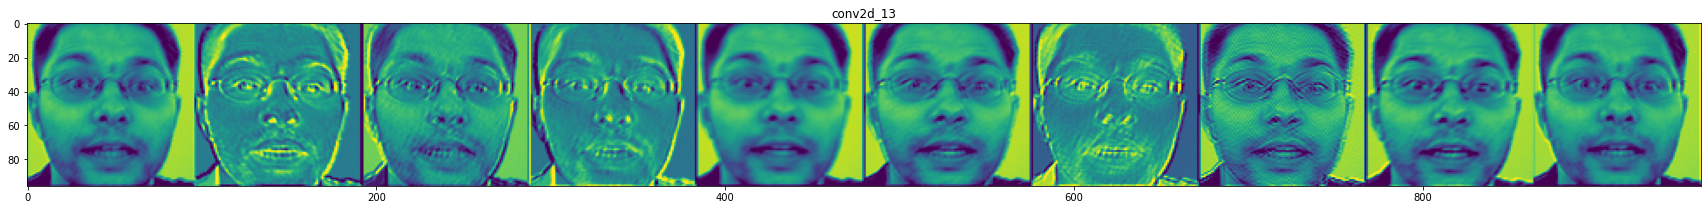

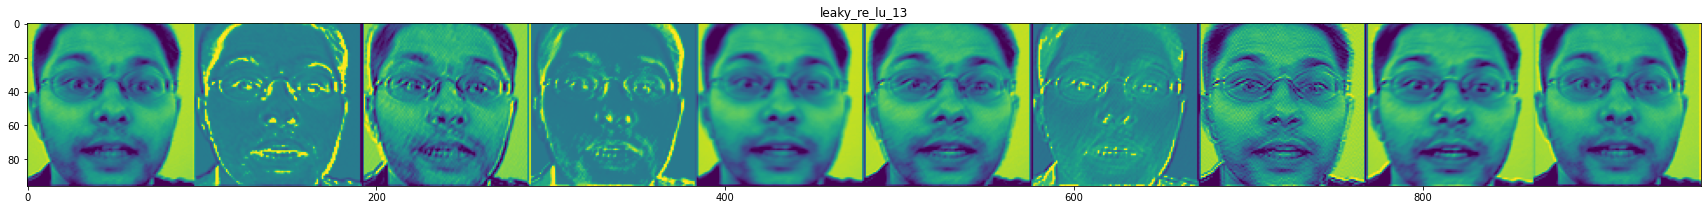

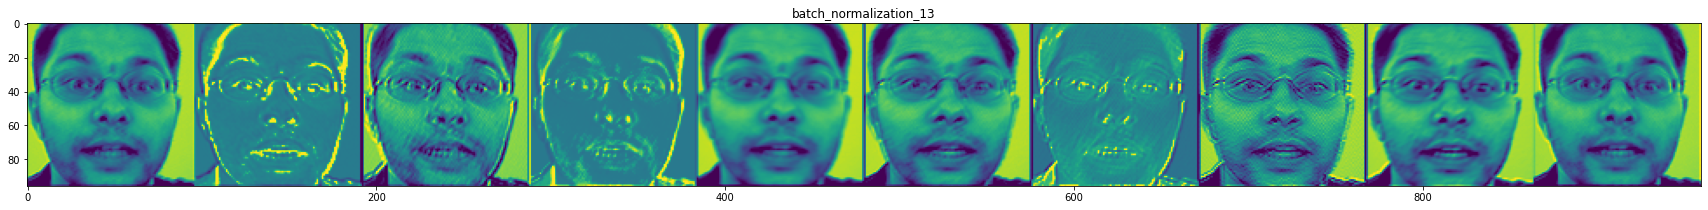

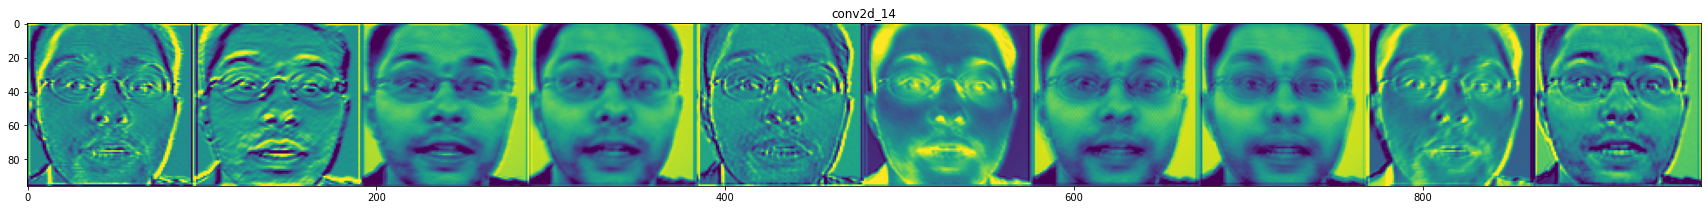

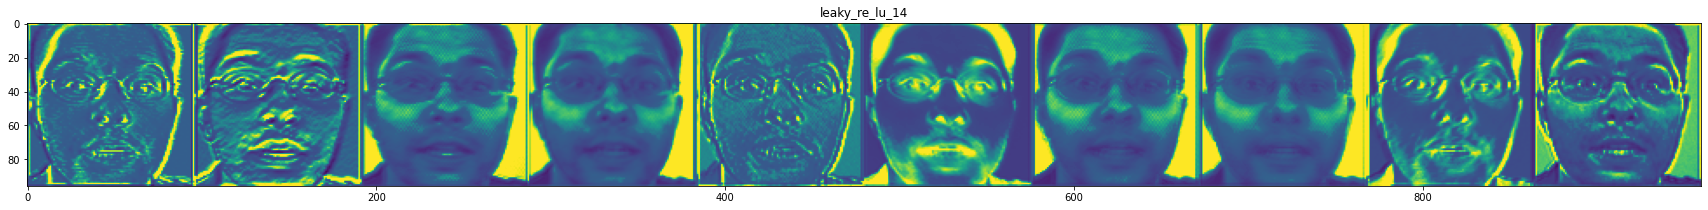

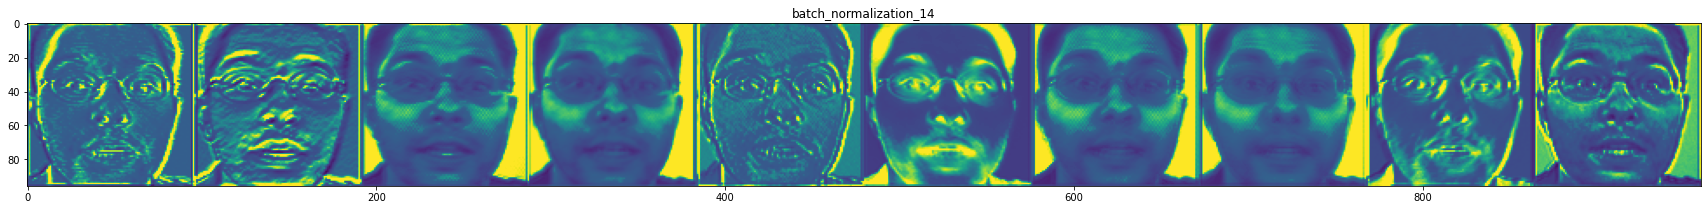

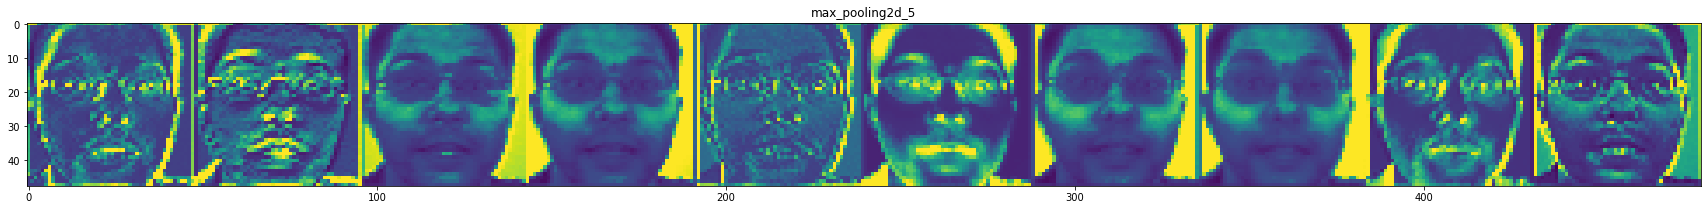

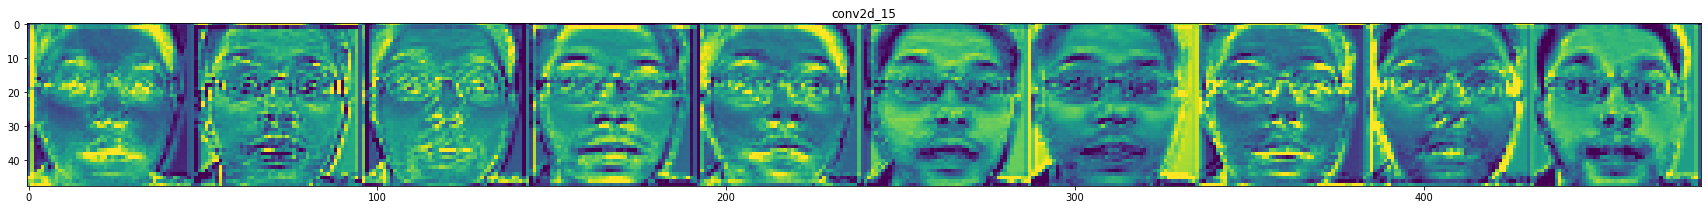

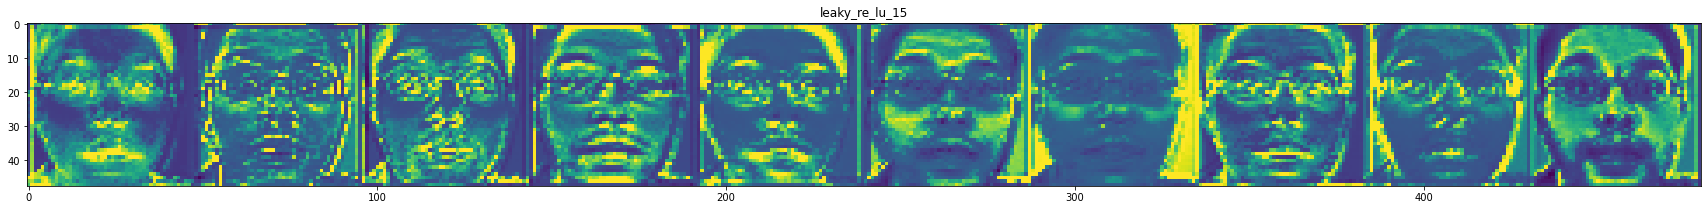

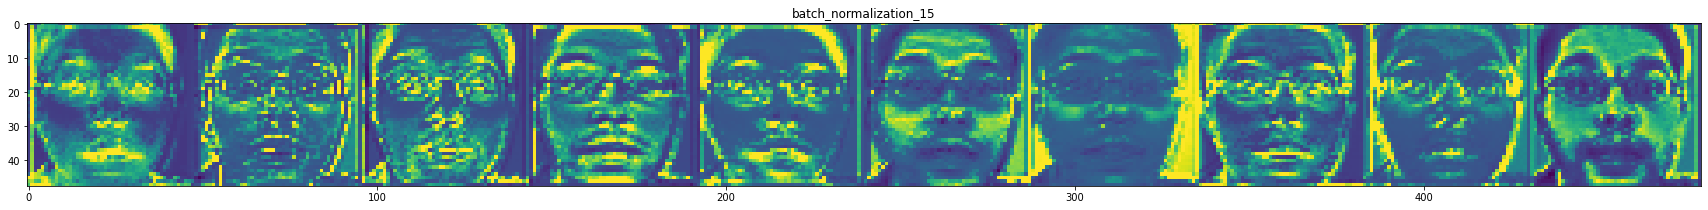

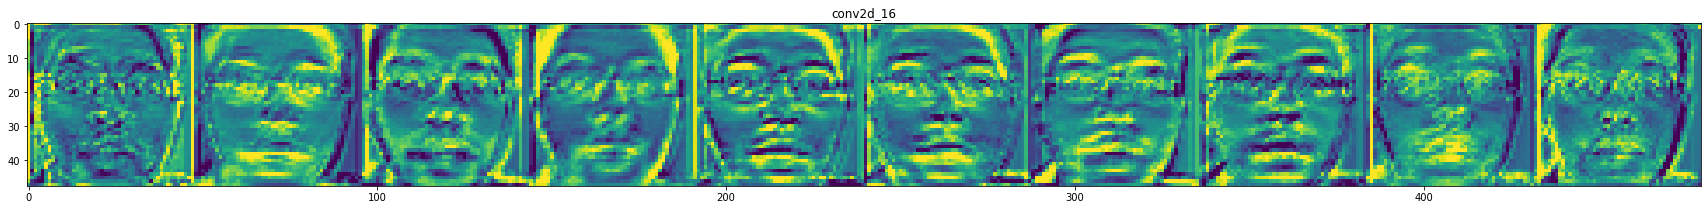

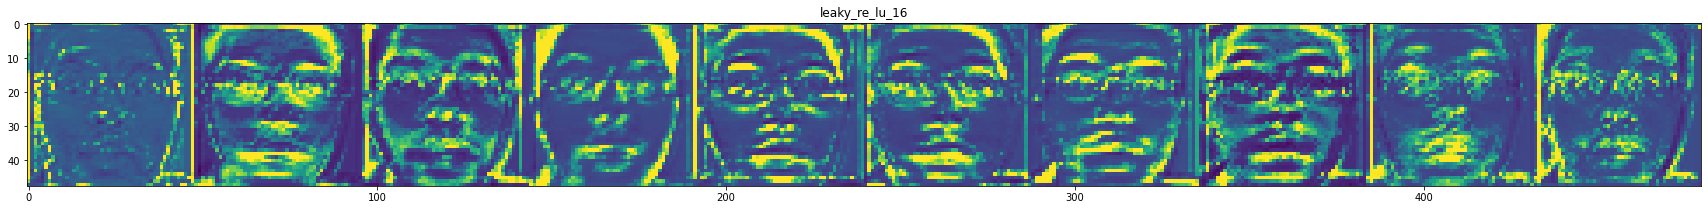

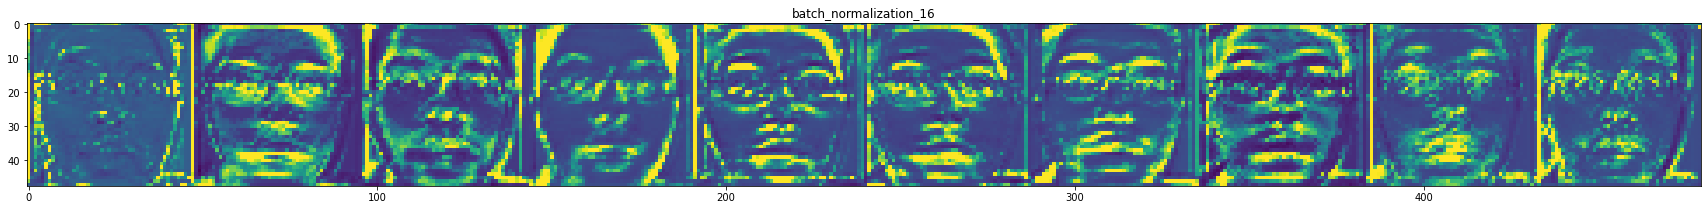

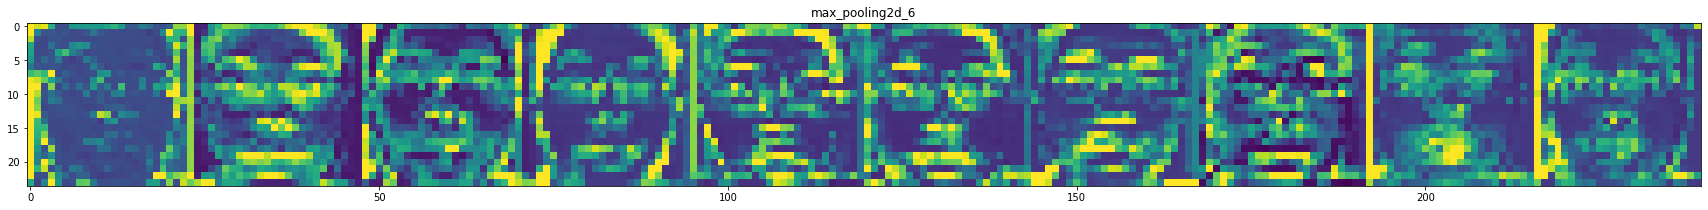

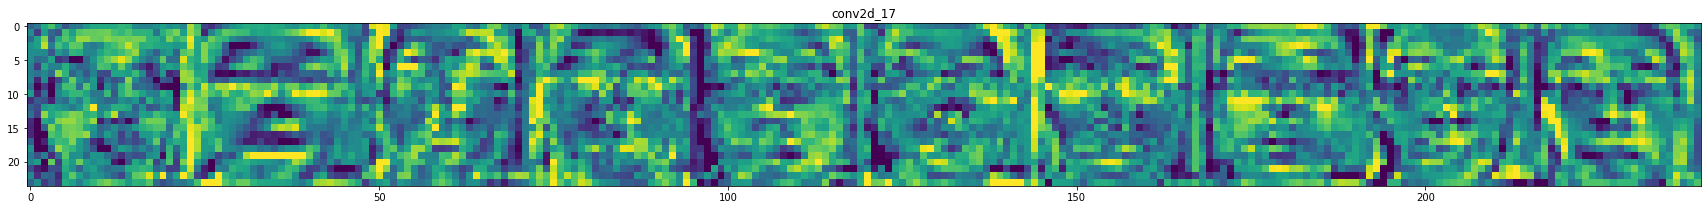

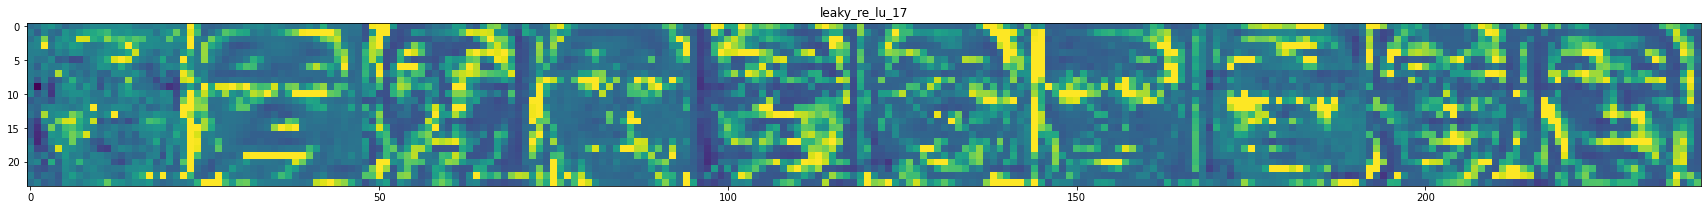

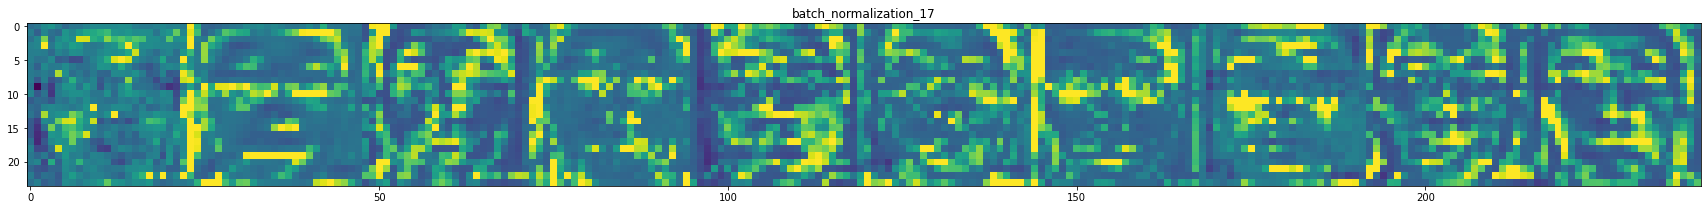

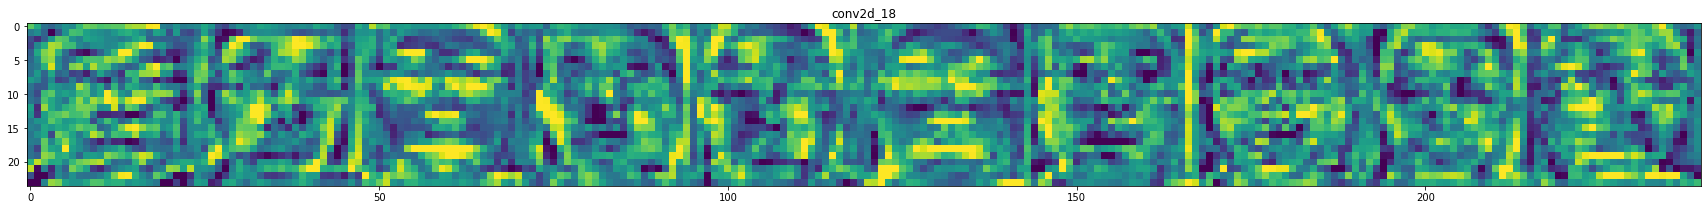

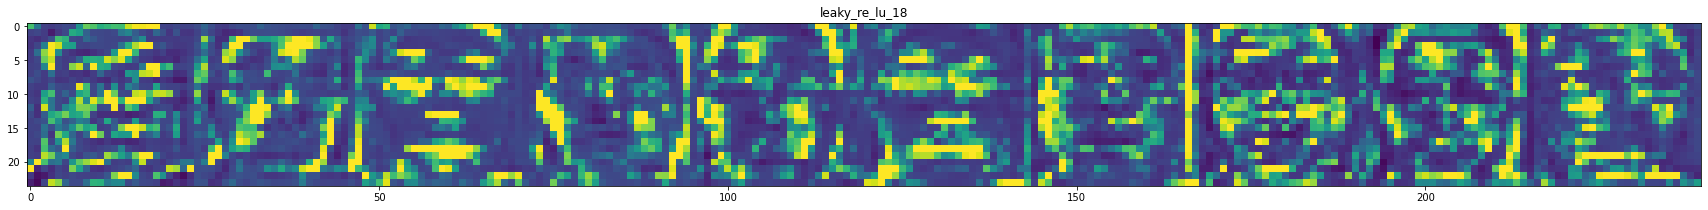

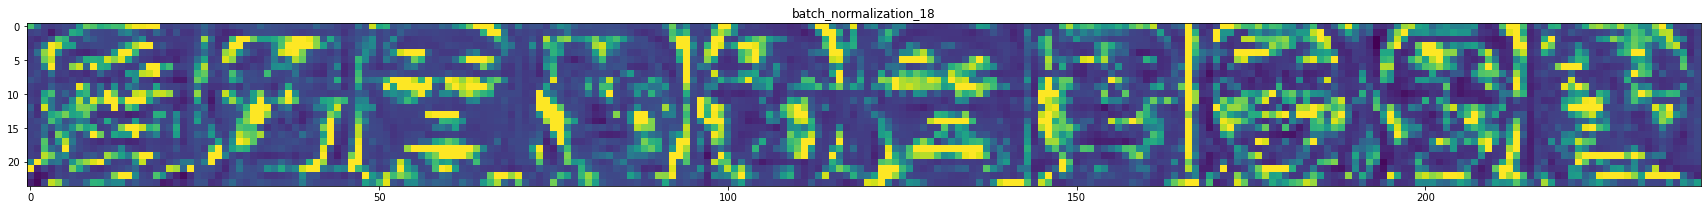

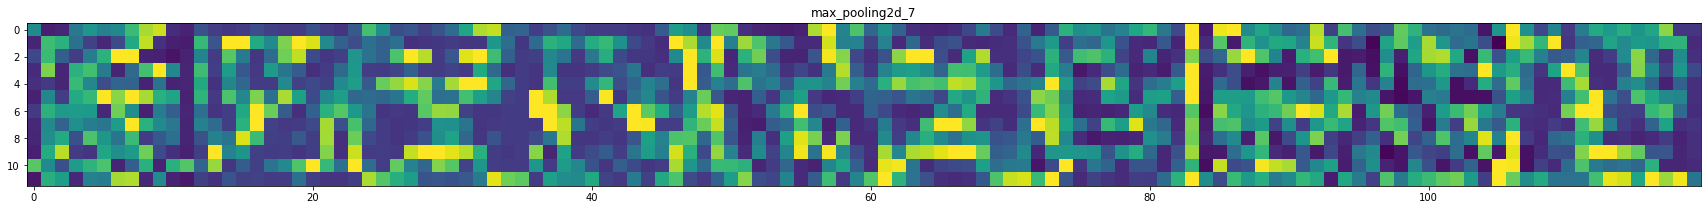

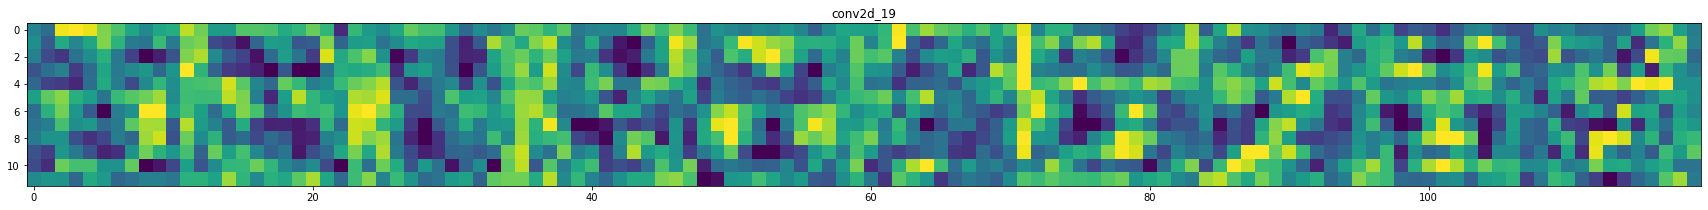

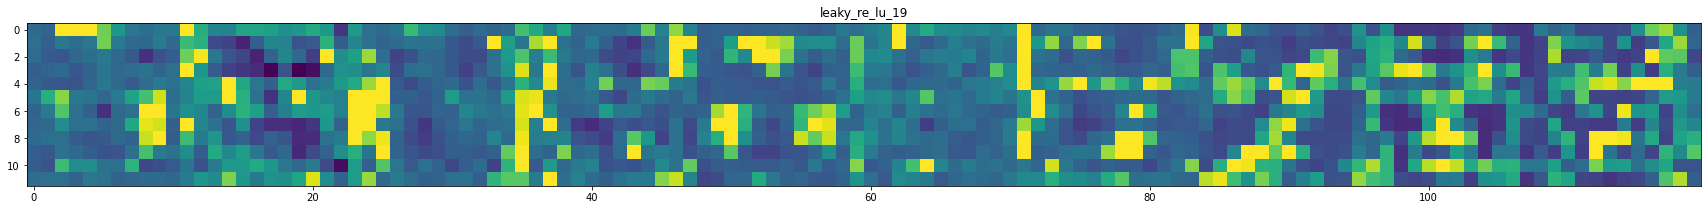

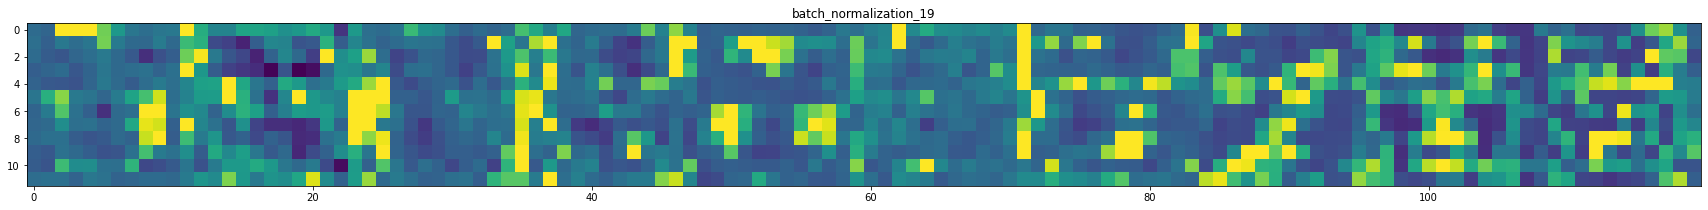

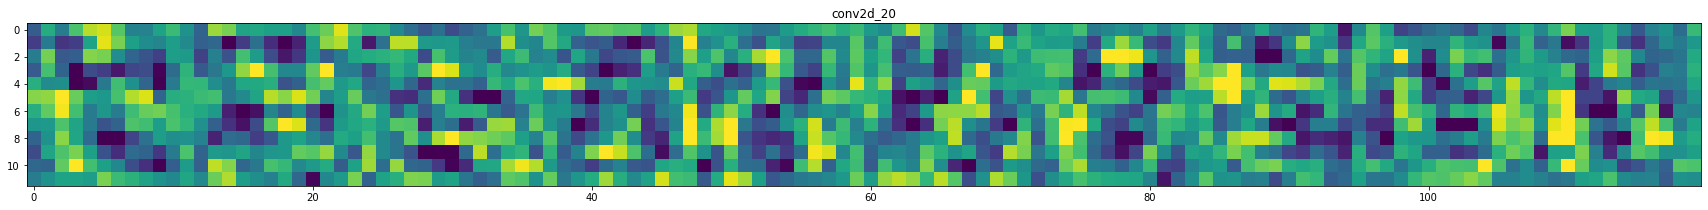

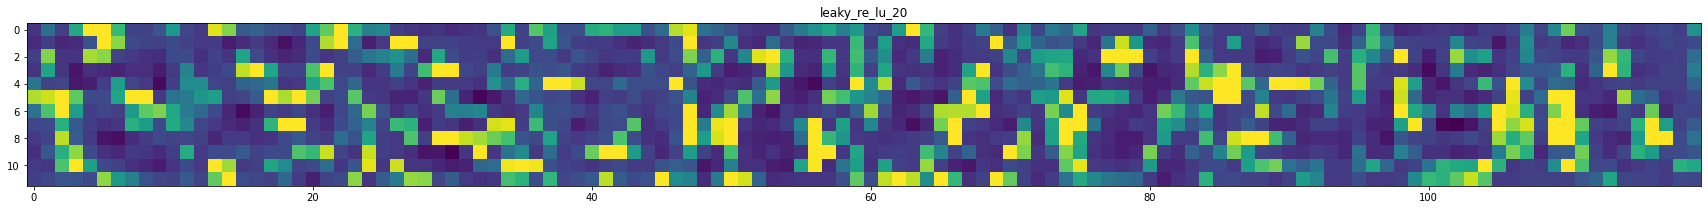

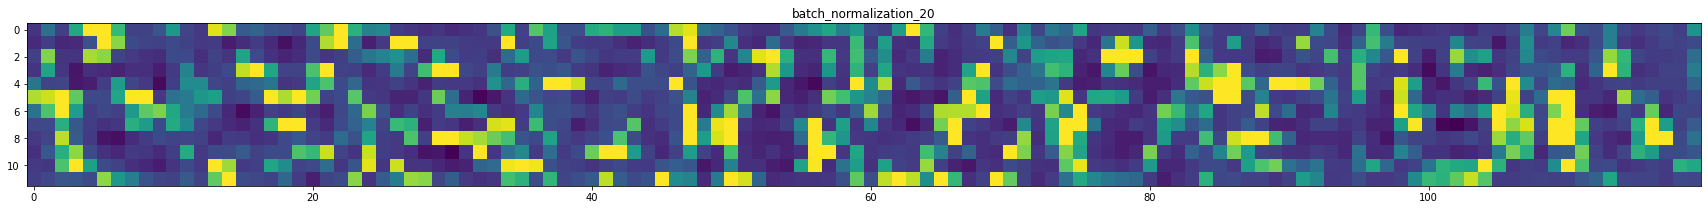

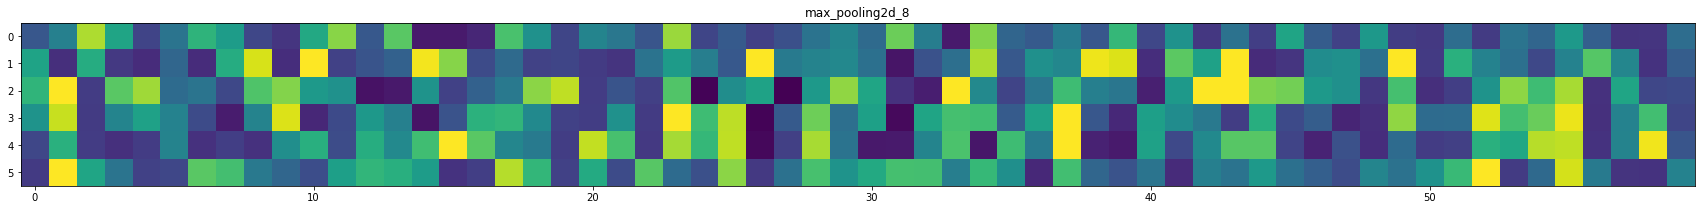

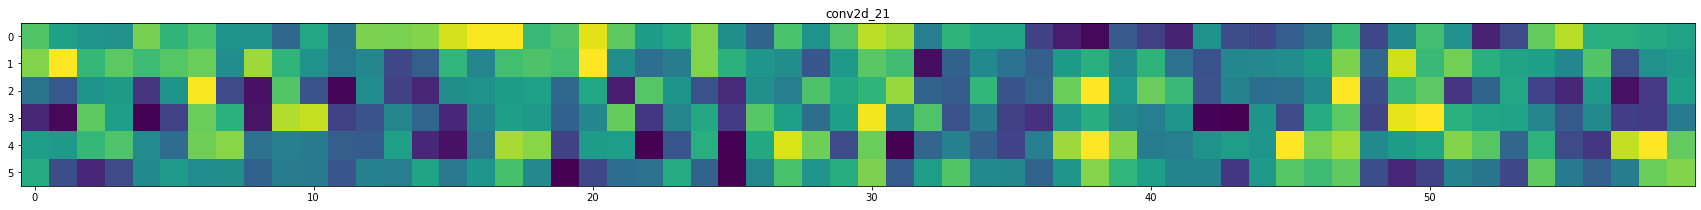

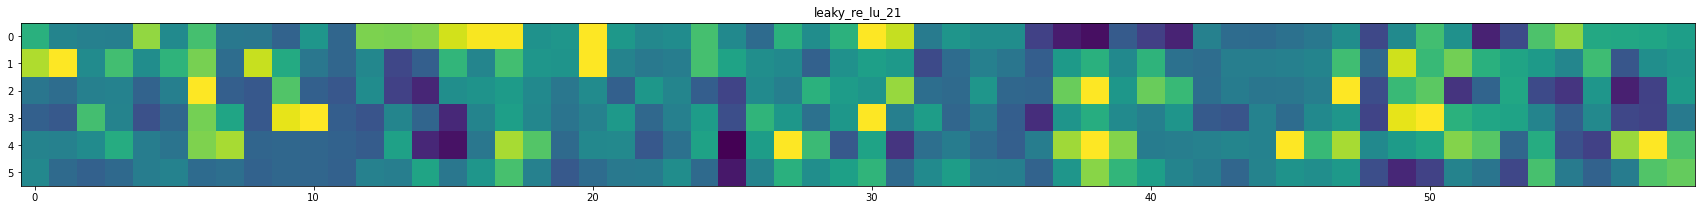

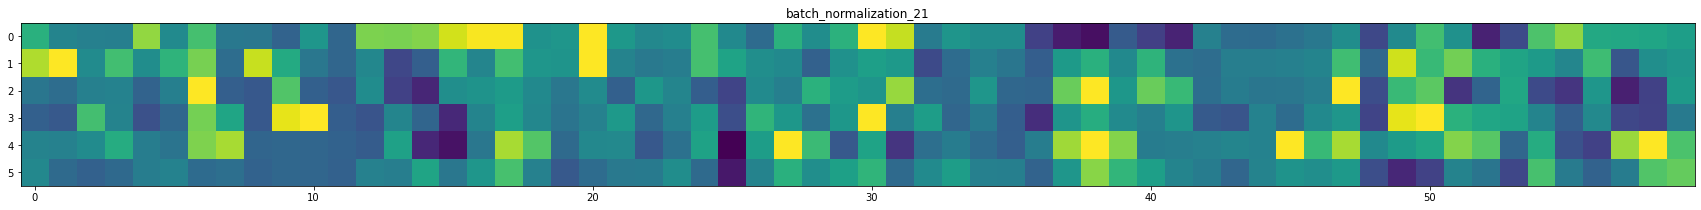

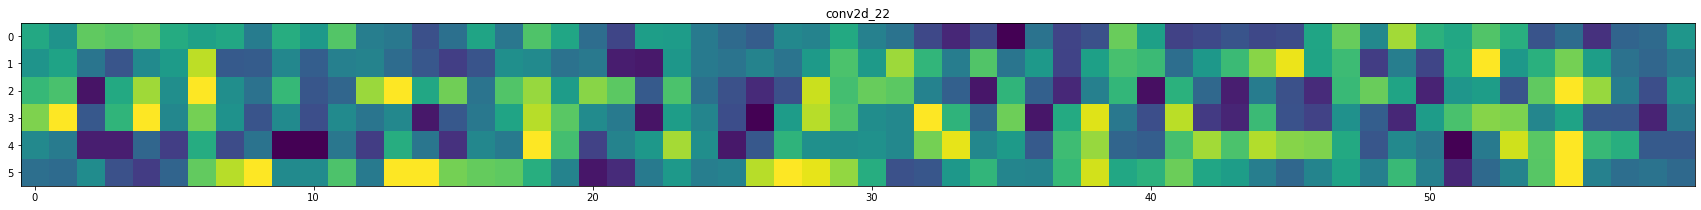

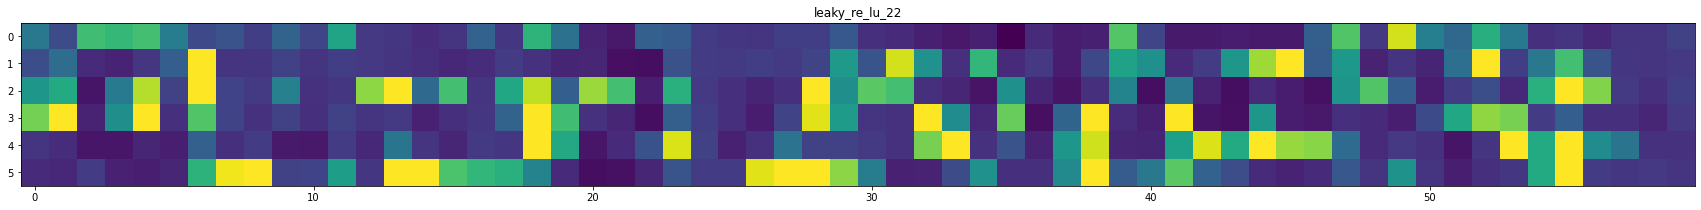

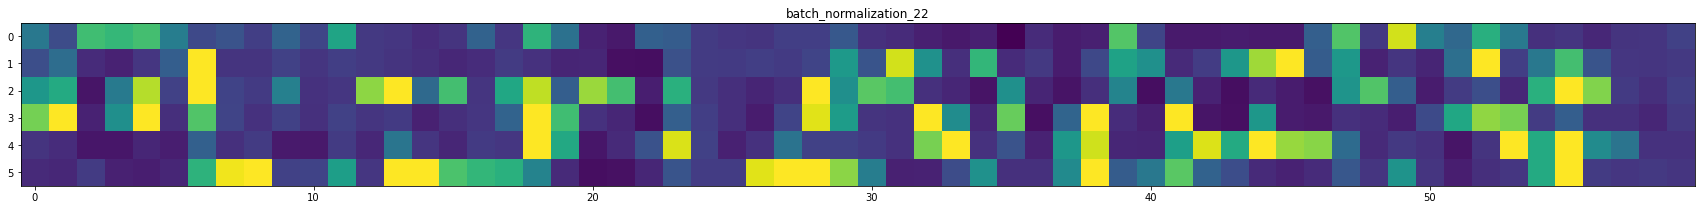

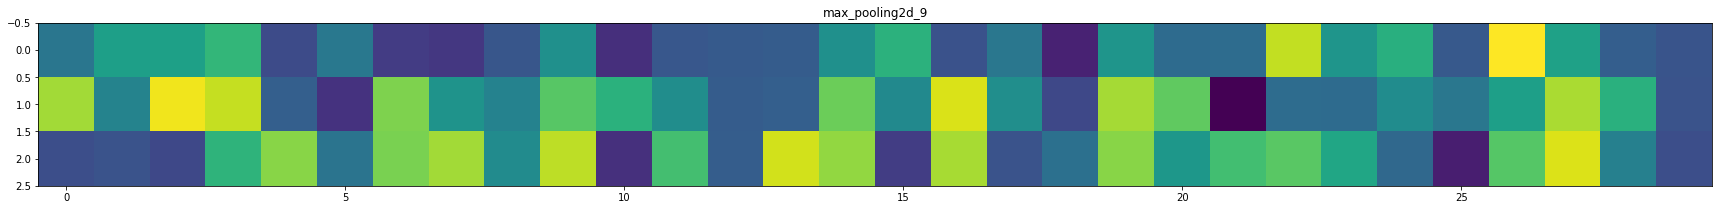

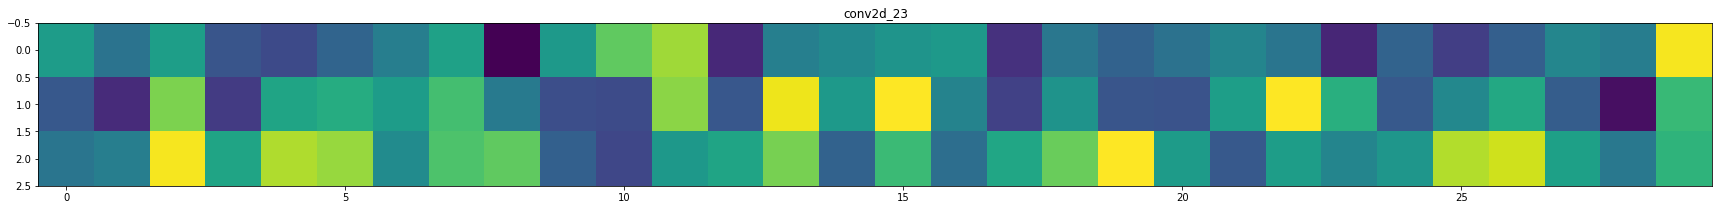

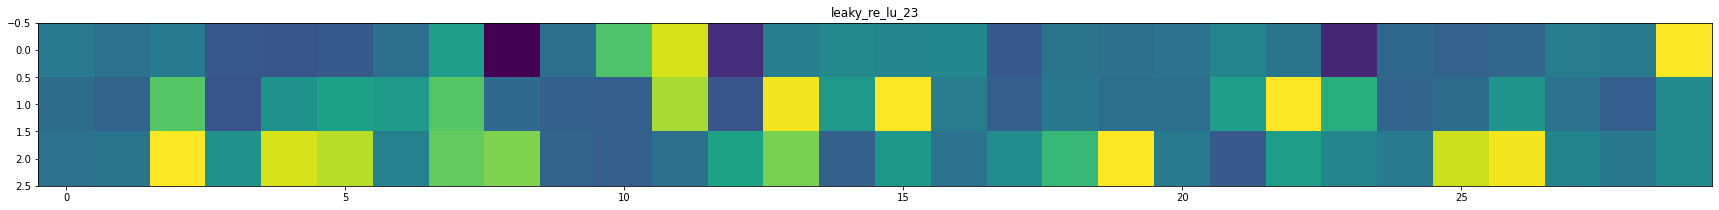

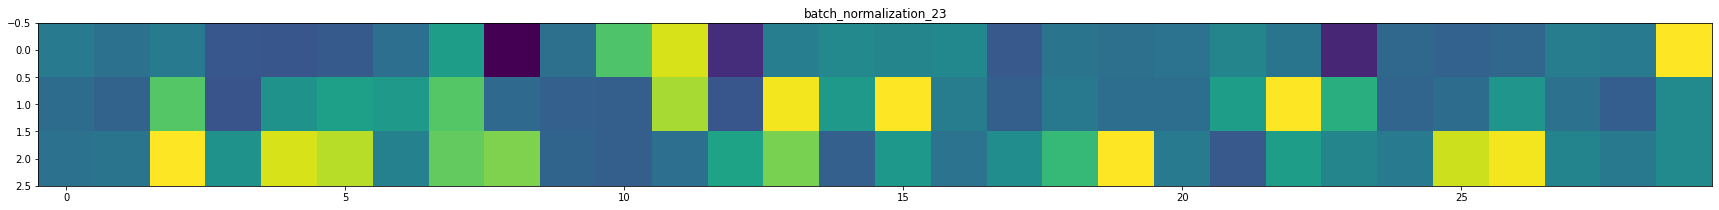

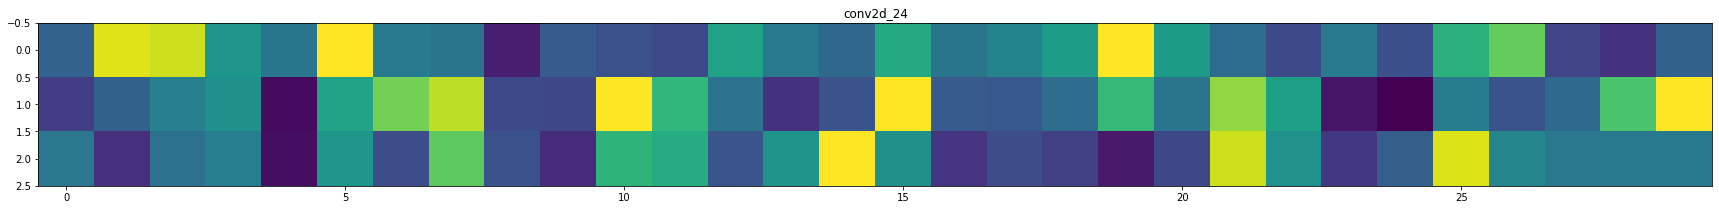

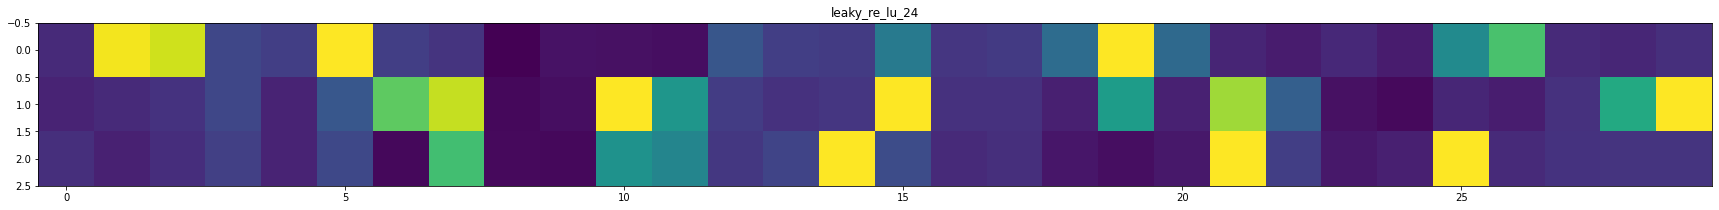

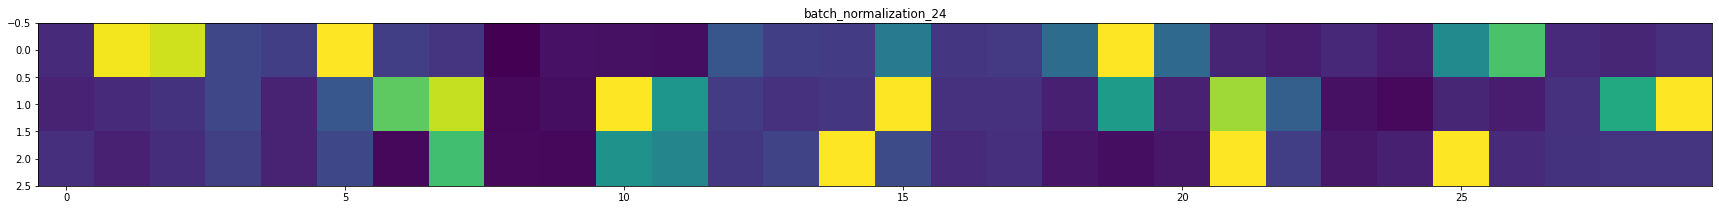

In [ ]:
model = model2
layer_names = [layer.name for layer in model.layers]
intermediate_outputs = [layer.output for layer in model.layers]
visualization_model = Model(inputs = model.input, outputs = intermediate_outputs)

n = 10 # number of random filters to display per layer
x = X_test[0:2]
feature_maps = visualization_model.predict(x)

for layer_name, feature_map in zip(layer_names, feature_maps):    
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1] 
    size = feature_map.shape[ 1]
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n))
    
    # Postprocess the feature to be visually palatable
    for i, idx in enumerate(np.random.randint(0, n_features, n)):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    # Display the grid
    scale = 3
    plt.figure(figsize=(scale * n, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## 5. Submission

In [ ]:
# [SELECT YOUR MODEL]
# predictions = model1.predict(X_test)
# predictions = model2.predict(X_test)
predictions = model3.predict(X_test)

print(f'Shape: {predictions.shape}')
print(f'Min: {predictions.min()} - Max: {predictions.max()}')

# Post-process predictions
predictions[predictions > 96] = 96
print(f'Shape: {predictions.shape}')
print(f'Min: {predictions.min()} - Max: {predictions.max()}')

In [ ]:
# Lookup table filters out the expected prediction points landmarks for each test image
lookid_data = pd.read_csv('IdLookupTable.csv')

image_id = list(lookid_data['ImageId']-1)
landmark_names = list(lookid_data['FeatureName'])
landmark_ids = [ landmark_names.index(f) for f in landmark_names ]

expected_preds = [ predictions[x,y] for x,y in zip(image_id, landmark_ids) ]

rowid = pd.Series(lookid_data['RowId'], name = 'RowId')
loc = pd.Series(expected_preds, name = 'Location')
submission = pd.concat([rowid, loc], axis = 1)
print(submission.shape)
submission.head()

In [ ]:
# Save predictions as .csv
submission.to_csv('preds_model.csv',index = False)

# Send submission to Kaggle
!kaggle competitions submit -f 'preds_model.csv' -m 'ConvNet with augmented data' facial-keypoints-detection

In [ ]:
# Summary of past submissions
!kaggle competitions submissions facial-keypoints-detection